## LSTM-FCN For Multivariate Time Series FOG Classification

## Imports

In [1]:
# !pip install tsai
from tsai.all import *
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/SYDE 599 - Deep Learning/SYDE 599 Project/Group Project"
# data_path = f"{base_path}/data/Filtered Data"

# Import data if df hasn't been defined yet (try/except for caching)
# try: 
#   df
# except NameError:
df = pd.read_csv(base_path + "/cleaned_data.zip")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('cleaned_data.csv')

In [3]:
locs = []

for i in range(1, 14):
    patient_id = i
    if i == 1:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 2:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 3:
        for j in range(3, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 4:
        for j in range(1, 6):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 5:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 6:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 7:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 8:
        for j in range(3, 6):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 9:
        for j in range(1, 7):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 10:
        for j in range(3, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 11:
        locs.append((patient_id, 1))
        locs.append((patient_id, 3))
        locs.append((patient_id, 4))
    if i == 12:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 13:
        for j in range(3, 5):
            task_id = j
            locs.append((patient_id, task_id))

## Creating Windows

In [29]:
def create_sliding_windows(dataframe, horizon):
    features_df = dataframe[['Electrooculogram', 'ECG', 'EMG_R-TA', 'EMG_L-TA', 'EMG_R-GS', 'SC', 'LS_acc_x', 'LS_acc_y', 'LS_acc_z',
       'LS_gyro_x', 'LS_gyro_y', 'LS_gyro_z', 'RS_acc_x', 'RS_acc_y',
       'RS_acc_z', 'RS_gyro_x', 'RS_gyro_y', 'RS_gyro_z', 'Waist_acc_x',
       'Waist_acc_y', 'Waist_acc_z', 'Waist_gyro_x', 'Waist_gyro_y',
       'Waist_gyro_z', 'Arm_acc_x', 'Arm_acc_y', 'Arm_acc_z', 'Arm_gyro_x',
       'Arm_gyro_y', 'Arm_gyro_z', "FoG"]]
    features = torch.tensor(features_df.values).float()
    
    # create samples with sliding window approach
    # A two second window will be 500Hz * 2 = 1000 
    window_length = 1000
    stride = None
    n_vars = 30
    get_x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
    get_y = 30

    # With sliding window 1000 and no overlap (stride of None)
    # 7530 samples, of 30 features, for 1000 time steps in each sample

    # horizon defines the amount of look forward 
    # here it's 0 so it's predicting the next time step FoG Label

    X, y = SlidingWindow(window_length, stride=250, get_x=get_x, get_y=get_y, horizon=horizon)(features)

    # X dims are (samples, features, time steps)
#     print(f"X shape is: {X.shape}")
    # y are the FOG labels (samples,)
#     print(f"y shape is: {y.shape}")
    
    return(X, y)


In [36]:
def create_sliding_windows_all_0s(dataframe, window_size=1000, stride=1000, horizon=250):
    # create sliding windows where the df["FoG"] is 0

    # Default Values:
    # window_size = 250  # 0.5 seconds
    # stride = 250  # to prevent overlap
    # horizon = 1  # to predict the next time step

    # slide a window of 250 samples across the data

    # if all the FoG labels are 0 index [30], then add that window to the X and y
    # if not, move one label forward and check again

    # y is the FoG labels for the next horizon time steps

    features_df = dataframe[
        ['Electrooculogram', 'ECG', 'EMG_R-TA', 'EMG_L-TA', 'EMG_R-GS', 'SC', 'LS_acc_x', 'LS_acc_y',
         'LS_acc_z',
         'LS_gyro_x', 'LS_gyro_y', 'LS_gyro_z', 'RS_acc_x', 'RS_acc_y',
         'RS_acc_z', 'RS_gyro_x', 'RS_gyro_y', 'RS_gyro_z', 'Waist_acc_x',
         'Waist_acc_y', 'Waist_acc_z', 'Waist_gyro_x', 'Waist_gyro_y',
         'Waist_gyro_z', 'Arm_acc_x', 'Arm_acc_y', 'Arm_acc_z', 'Arm_gyro_x',
         'Arm_gyro_y', 'Arm_gyro_z', "FoG"]]
    features = torch.tensor(features_df.values).float()

    # size (0, 30, 250)
    trainset_X = np.empty((0, 30, window_size))
    trainset_y = np.empty((0, horizon))
    i = 0

    while i <= features.shape[0] - window_size - horizon:
        if features[i:i + window_size, 30].sum() == 0:
            window_features = features[i:i + window_size, 0:30]
            window_features = window_features.reshape(1, 30, window_size)
            trainset_X = np.append(trainset_X, window_features, axis=0)
            horizon_window = features[i + window_size:i + window_size + horizon, 30]
            horizon_window = horizon_window.reshape(1, horizon)
            trainset_y = np.append(trainset_y, horizon_window, axis=0)
            i += stride
        else:
            i += 1

    return trainset_X, trainset_y

In [37]:
df_patient_task = df[(df["Patient_ID"] == 1) & (df["Task_ID"] == 1)]
X, y = create_sliding_windows_all_0s(df_patient_task)

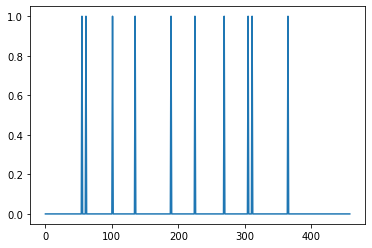

In [14]:
plt.plot(y)


In [47]:
trainset = {}
testset = {}

horizon = 250

for loc in locs:
    df_patient_task = df[(df["Patient_ID"] == loc[0]) & (df["Task_ID"] == loc[1])]
    X, y = create_sliding_windows_all_0s(df_patient_task, horizon=horizon)
#     X, y = create_sliding_windows(df_patient_task)
    if loc[0] != 13 and loc[0] != 12:
      trainset[loc] = (X, y)
    else:
      testset[loc] = (X, y)
    dim1 = X.shape[1]
    dim2 = X.shape[2]
    
trainset_X = np.empty((0, dim1, dim2))
trainset_y = np.empty((0, horizon))
testset_X = np.empty((0, dim1, dim2))
testset_y = np.empty((0, horizon))

for key in trainset:
    X, y = trainset[key]
    trainset_X = np.concatenate((trainset_X, X), axis=0)
    trainset_y = np.concatenate((trainset_y, y), axis=0)
    
for key in testset:
    X, y = testset[key]
    testset_X = np.concatenate((testset_X, X), axis=0)
    testset_y = np.concatenate((testset_y, y), axis=0)



In [49]:
testset_y.shape

(413, 250)

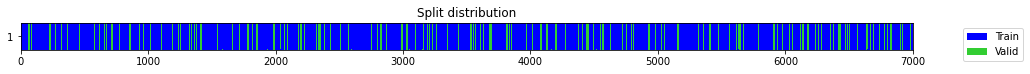

In [ ]:
splits = get_splits(trainset_y, valid_size=.2, stratify=True, random_state=23, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(y.shape)


(40,)


#Training

In [ ]:
# ts = get_forecasting_time_series("Sunspots").values
# X, y = SlidingWindow(1000, horizon=3)(ts)
# splits = TimeSplitter(235)(y) 
print(X.shape)

print(trainset_y[0:100])
# print(ts)
print(splits)


(40, 30, 1000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
([1308, 4504, 85, 6946, 4614, 761, 6173, 5241, 5252, 2596, 2024, 4260, 4406, 1589, 6296, 723, 147, 6086, 5738, 4596, 2933, 586, 191, 5547, 747, 1785, 1605, 3386, 712, 2432, 1252, 3688, 6813, 3893, 1585, 6606, 3714, 3929, 1193, 6831, 2819, 5612, 4067, 2419, 2864, 4294, 6916, 3747, 4672, 6617, 6649, 6750, 5880, 2956, 1429, 4555, 5057, 503, 5808, 6298, 1403, 674, 3481, 2755, 4574, 3432, 2084, 1677, 5184, 3019, 4480, 5470, 377, 2501, 4084, 1144, 951, 6777, 3502, 2450, 3290, 4423, 4318, 5879, 3185, 1239, 5068, 6631, 5064, 3493, 2312, 2396, 3743, 5674, 659, 5492, 1642, 1077, 3856, 149, 6452, 5621, 1125, 4689, 1116, 200, 6520, 6175, 328, 2955, 5490, 1103, 5887, 4717, 6075, 790,

In [ ]:
nFoG = [element for element in trainset_y if element == 0]
print(len(nFoG))

FoG = [element for element in trainset_y if element == 1]
print(len(FoG))

4982
2022


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.562491,0.526226,0.729686,0.727683,00:12
1,0.450902,0.433711,0.744781,0.730775,00:06
2,0.408326,0.378088,0.804435,0.804659,00:04
3,0.360460,0.334351,0.820818,0.820818,00:04
4,0.334533,0.304694,0.827721,0.824367,00:04
5,0.313870,0.295632,0.835094,0.841321,00:04
6,0.305387,0.319271,0.816102,0.829973,00:05
7,0.312301,0.307883,0.823771,0.812363,00:04
8,0.292039,0.263724,0.870493,0.870765,00:05
9,0.273197,0.279045,0.845010,0.848582,00:06


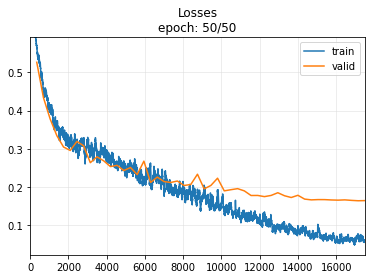

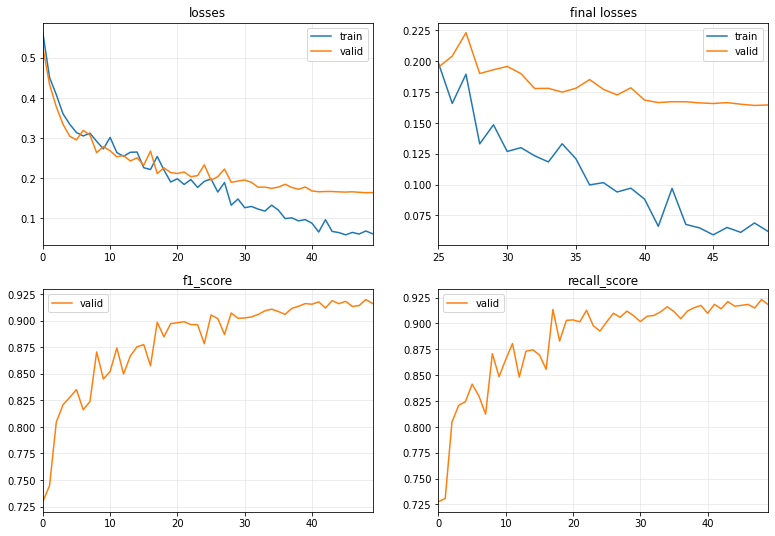

In [ ]:
batch_tfms = TSStandardize()
fcst = TSForecaster(trainset_X, trainset_y, splits=splits, loss_func=BCEWithLogitsLossFlat(), path='models', bs=16, arch=LSTM_FCNPlus, metrics=[ F1ScoreMulti(), RecallMulti()], cbs=ShowGraph())
fcst.fit_one_cycle(50, 1e-3)
fcst.export("fcst.pkl")

In [ ]:
batch_tfms = TSStandardize()
fcst = TSForecaster(trainset_X, trainset_y, splits=splits, loss_func=BCEWithLogitsLossFlat(), path='models', bs=16, arch=LSTM_FCNPlus, metrics=[ F1ScoreMulti(), RecallMulti()], cbs=ShowGraph())
fcst.fit_one_cycle(50, 1e-3)
fcst.export("fcst1.pkl")

In [ ]:
splits

In [ ]:
from tsai.inference import load_learner
actual = [0 if target == 0 else 1 for target in testset_y[splits[1]]]

fcst = load_learner("models/fcst.pkl", cpu=False)
raw_preds, target, preds = fcst.get_X_preds(testset_X[splits[1]])
predicted = [0 if pred[0] == False else 1 for pred in preds]


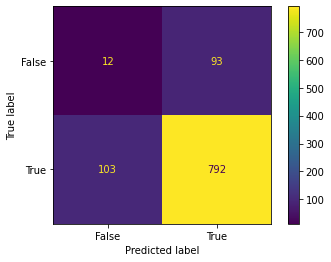

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
tp = confusion_matrix[1,1]
fp = confusion_matrix[0,1]
fn = confusion_matrix[1,0]
pre = tp/(tp+fp)
re = tp/(tp+fn)
f1 = 2*pre*re/(pre+re)

print(pre, re, f1)

0.8949152542372881 0.8849162011173184 0.8898876404494381
